### MLR

In [ ]:
df_tomm.columns

Index(['날짜', 'PM10', 'PM25', 'O3', 'NO2', 'SO2', 'tem', 'rain', 'hum', 'vapor',
       'dew', 'press', 'cloud', 'wind_x', 'wind_y', 'ammonia', 'toluen',
       'methyle', 'benzene', 'tomm_pm'],
      dtype='object')

In [ ]:
df_tomm = df_tomm.interpolate(how = 'linear')
df_tomm.shape

(26304, 20)

In [ ]:
df_tomm = df_tomm.set_index('날짜')

In [ ]:
air_train_tomm = df_tomm[df_tomm.index.astype(str).str[:4] == '2019']
air_valid_tomm = df_tomm[df_tomm.index.astype(str).str[:4] == '2020']
air_test_tomm = df_tomm[df_tomm.index.astype(str).str[:4] == '2021']

x_train_tomm = air_train_tomm.drop('tomm_pm', axis = 1)
y_train_tomm = air_train_tomm['tomm_pm']
x_valid_tomm = air_valid_tomm.drop('tomm_pm', axis = 1)
y_valid_tomm = air_valid_tomm['tomm_pm']
x_test_tomm = air_test_tomm.drop('tomm_pm', axis = 1)
y_test_tomm = air_test_tomm['tomm_pm']

In [ ]:
air_train_tomm.shape

(8760, 19)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred, squared = False), 5)

def mae(y_true, y_pred):
    return round(mean_absolute_error(y_true, y_pred), 5)

In [ ]:
x_valid_tomm.shape, y_valid_tomm.shape

((8784, 18), (8784,))

In [ ]:
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()
mlr.fit(x_train_tomm, y_train_tomm)

pred = mlr.predict(x_test_tomm)
print('rmse : ', rmse(y_test_tomm, pred))
print('mae : ', mae(y_test_tomm, pred))

rmse :  12.64398
mae :  9.15472


### DNN MODEL

In [ ]:
dnn_train_x = train_scaled[['PM25', 'O3', 'NO2', 'SO2', 'tem', 'rain', 'wind_x', 'wind_y', 'hum',
       'press', 'cloud', 'ammonia', 'toluen', 'methyle']]
dnn_train_y = x_train[['tomm_pm']]
dnn_valid_x = valid_scaled[['PM25', 'O3', 'NO2', 'SO2', 'tem', 'rain', 'wind_x', 'wind_y', 'hum',
       'press', 'cloud', 'ammonia', 'toluen', 'methyle']]
dnn_valid_y = x_valid[['tomm_pm']]
dnn_test_x = test_scaled[['PM25', 'O3', 'NO2', 'SO2', 'tem', 'rain', 'wind_x', 'wind_y', 'hum',
       'press', 'cloud', 'ammonia', 'toluen', 'methyle']]
dnn_test_y = x_test[['tomm_pm']]

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow import keras
import tensorflow as tf

tf.random.set_seed(1)

dnn_model = tf.keras.models.Sequential()
dnn_model.add(Dense(64,
               input_shape=(dnn_train_x.shape[1],),
               activation='tanh'))
dnn_model.add(Dropout(0.1))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(1))

dnn_model.compile(loss='mse', metrics=['mae'], optimizer=keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_lr=0.00001)
checkpoint_cb = keras.callbacks.ModelCheckpoint('dnn.h5')
early_stop = EarlyStopping(monitor='val_loss',patience=200, restore_best_weights=True)

history = dnn_model.fit(dnn_train_x, [dnn_train_y], epochs=10000,
                    validation_data=(dnn_valid_x, [dnn_valid_y]),
                    batch_size=64,
                    callbacks=[early_stop, checkpoint_cb, reduce_lr])

total_loss, main_loss = dnn_model.evaluate(dnn_test_x, [dnn_test_y])

Epoch 1/10000
122/122 [==============================] - 1s 5ms/step - loss: 286.8246 - mae: 12.6538 - val_loss: 142.0106 - val_mae: 9.2577 - lr: 0.0100
Epoch 2/10000
122/122 [==============================] - 0s 4ms/step - loss: 166.6357 - mae: 9.6816 - val_loss: 144.0298 - val_mae: 9.2995 - lr: 0.0100
Epoch 3/10000
122/122 [==============================] - 0s 4ms/step - loss: 158.5789 - mae: 9.4189 - val_loss: 142.3834 - val_mae: 9.2491 - lr: 0.0100
Epoch 4/10000
122/122 [==============================] - 1s 4ms/step - loss: 153.4490 - mae: 9.2724 - val_loss: 145.4914 - val_mae: 9.3441 - lr: 0.0100
Epoch 5/10000
122/122 [==============================] - 0s 4ms/step - loss: 148.4171 - mae: 9.0995 - val_loss: 144.3056 - val_mae: 9.3062 - lr: 1.0000e-04
Epoch 6/10000
122/122 [==============================] - 1s 4ms/step - loss: 147.2818 - mae: 9.0812 - val_loss: 143.8264 - val_mae: 9.2951 - lr: 1.0000e-04
Epoch 7/10000
122/122 [==============================] - 0s 4ms/step - loss: 14

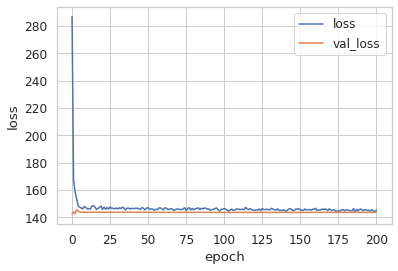

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
pred = dnn_model.predict([dnn_test_x])
print('Loss', dnn_model.evaluate(dnn_test_x, [dnn_test_y]))

239/239 [==============================] - 0s 1ms/step - loss: 158.8686 - mae: 9.1614
Loss [158.8685760498047, 9.161355972290039]


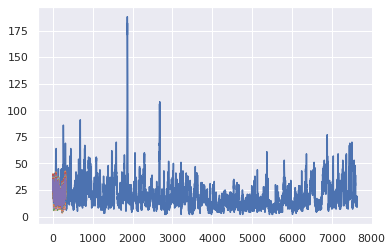

In [ ]:
plt.plot(dnn_test_y)
plt.plot(pred)

In [ ]:
test_10days = dnn_test_x
dnn_10days = pd.DataFrame(dnn_model.predict([test_10days]))

In [ ]:
actual = dnn_test_y
actual = actual.reset_index()
print(actual.columns)

Index(['index', 'tomm_pm'], dtype='object')


In [ ]:
dnn_10days['actual'] = actual['tomm_pm']

In [ ]:
dnn_date = air_test[24:]
dnn_date = dnn_date.reset_index()
dnn_10days['date'] = dnn_date['date']

In [ ]:
dnn_10days['daily'] = dnn_10days['date'].astype(str).str[:10]
dnn_10days['daily'] = pd.to_datetime(dnn_10days['daily'])
dnn_10days = dnn_10days.dropna(how='any')
print(dnn_10days.columns)

Index([0, 'actual', 'date', 'daily'], dtype='object')


In [ ]:
dnn_10days

,0,actual,date,daily
0,25.450209,20.0,2021-01-02 00:00:00,2021-01-02
1,27.199287,24.0,2021-01-02 01:00:00,2021-01-02
2,29.557430,23.0,2021-01-02 02:00:00,2021-01-02
3,26.025185,22.0,2021-01-02 03:00:00,2021-01-02
4,25.155272,21.0,2021-01-02 04:00:00,2021-01-02
...,...,...,...,...
7613,33.528976,15.0,2021-12-30 19:00:00,2021-12-30
7614,30.136871,11.0,2021-12-30 20:00:00,2021-12-30
7615,29.534863,16.0,2021-12-30 21:00:00,2021-12-30
7616,28.302404,19.0,2021-12-30 22:00:00,2021-12-30


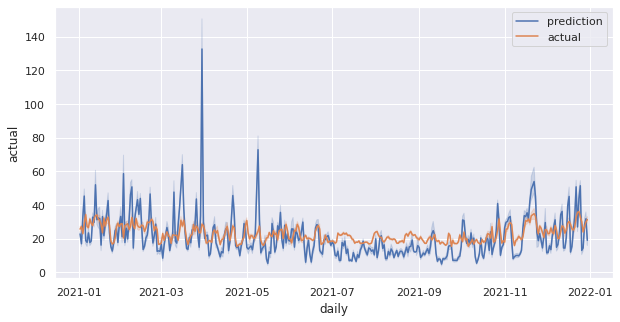

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data = dnn_10days, x = 'daily', y = dnn_10days.actual)
sns.lineplot(data = dnn_10days, x= 'daily', y = dnn_10days[0])
plt.legend(['prediction', 'actual'])

### RNN MODEL (Simple RNN) 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Flatten, Dropout, Input
from tensorflow import keras
import tensorflow as tf

tf.random.set_seed(0)

rnn_model = tf.keras.models.Sequential()
rnn_model.add(SimpleRNN(128,
               input_shape=(x_train_multi.shape[1],x_train_multi.shape[2]),
               activation='tanh'))
rnn_model.add(Dropout(0.1))
rnn_model.add(Dense(24))

rnn_model.compile(loss='mse', metrics=['mae'], optimizer=keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm.h5', mode='min')
early_stop = EarlyStopping(monitor='val_loss',patience=300, restore_best_weights=True)

history = rnn_model.fit(x_train_multi, [y_train_multi], epochs=10000,
                    validation_data=(x_val_multi, [y_val_multi]),
                    batch_size=3,
                    callbacks=[early_stop,  checkpoint_cb])

total_loss, main_loss = rnn_model.evaluate(x_test_multi, [y_test_multi])

2023-01-16 15:09:27.520260: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10000
121/121 [==============================] - 1s 5ms/step - loss: 840.6597 - mae: 24.5893 - val_loss: 325.9576 - val_mae: 12.8424
Epoch 2/10000
121/121 [==============================] - 0s 3ms/step - loss: 444.3210 - mae: 15.7845 - val_loss: 189.3043 - val_mae: 10.3131
Epoch 3/10000
121/121 [==============================] - 0s 4ms/step - loss: 299.8923 - mae: 13.0021 - val_loss: 148.0843 - val_mae: 9.2171
Epoch 4/10000
121/121 [==============================] - 0s 4ms/step - loss: 216.0608 - mae: 10.6132 - val_loss: 209.1019 - val_mae: 10.6558
Epoch 5/10000
121/121 [==============================] - 0s 3ms/step - loss: 191.2600 - mae: 10.5133 - val_loss: 128.5295 - val_mae: 8.6457
Epoch 6/10000
121/121 [==============================] - 0s 3ms/step - loss: 182.5081 - mae: 10.0785 - val_loss: 134.9766 - val_mae: 9.1746
Epoch 7/10000
121/121 [==============================] - 0s 3ms/step - loss: 173.1681 - mae: 9.8172 - val_loss: 120.8265 - val_mae: 8.3760
Epoch 8/10000
121/

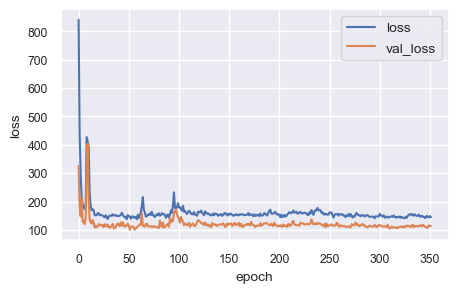

In [ ]:
import matplotlib.pyplot as plt
sns.set(font_scale=0.8)

plt.figure(figsize = (5, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch', fontsize = 10)
plt.ylabel('loss', fontsize = 10)
plt.legend(['loss', 'val_loss'], fontsize = 10)
plt.show()

In [ ]:
pred = rnn_model.predict([x_test_multi])
print('Loss', rnn_model.evaluate(x_test_multi, [y_test_multi]))

12/12 [==============================] - 0s 2ms/step - loss: 122.5456 - mae: 7.6510
Loss [122.54557037353516, 7.651011943817139]


In [ ]:
pred

array([[20.970419, 22.824078, 22.372433, ..., 27.997545, 28.149567,
        26.528164],
       [20.024199, 22.513409, 21.820774, ..., 26.883707, 27.99163 ,
        26.699017],
       [20.648771, 22.759968, 22.160023, ..., 27.700106, 28.070469,
        26.543415],
       ...,
       [24.738895, 26.575487, 25.00284 , ..., 28.509348, 29.120502,
        27.875538],
       [34.96992 , 36.064774, 35.059723, ..., 34.332962, 35.14055 ,
        33.967075],
       [26.67387 , 28.005579, 27.40237 , ..., 30.207748, 30.519363,
        28.997055]], dtype=float32)

In [ ]:
pred_df = pd.DataFrame()
real_df = pd.DataFrame()

for num in range(0, pred.shape[0]):
    real_df = real_df.append(pd.DataFrame(y_test_multi.reshape(-1, 24)[num]))
    pred_df = pred_df.append(pd.DataFrame(pred[num]))
pred_df.head(), real_df.head()

(           0
 0  20.970419
 1  22.824078
 2  22.372433
 3  24.644419
 4  25.105652,
       0
 0  20.0
 1  24.0
 2  23.0
 3  22.0
 4  21.0)

In [ ]:
pred_df = pred_df.reset_index().drop('index', axis = 1)[:-24]
real_df = real_df.reset_index().drop('index', axis = 1)[24:].reset_index().drop('index', axis = 1)
pred_df.shape, real_df.shape

((8688, 1), (8688, 1))

In [ ]:
min(pred_df[0]), max(pred_df[0])

(-6.782425880432129, 65.3641128540039)

In [ ]:
real_df.columns

Index([0], dtype='object')

In [ ]:
# 실제 관측값 & 모델 예측값
air_test.index[24:-48]
rnn_air_data = pd.DataFrame()
rnn_air_data['pred'] = pred_df[0]
rnn_air_data['real'] = real_df[0]
rnn_air_data['day'] = air_test.index[24:-48].astype(str).str[:-2]
rnn_air_data['date'] = air_test.index[24:-48]

In [ ]:
rnn_air_data.isnull().sum()

pred    0
real    0
day     0
date    0
dtype: int64

In [ ]:
rnn_air_data['real'] = rnn_air_data['real'].astype('float')
rnn_air_data['pred'] = rnn_air_data['pred'].astype('float')

In [ ]:
real = np.array(rnn_air_data['real'], dtype='float')
real.dtype

dtype('float64')

In [ ]:
min(real), max(real), min(rnn_air_data['pred']), max(rnn_air_data['pred'])

(2.0, 188.0, -6.782425880432129, 65.3641128540039)

In [ ]:
rnn_air_data.dtypes

pred    float64
real    float64
day      object
date     object
dtype: object

In [ ]:
rnn_air_data.date.value_counts()

2021010200    1
2021083103    1
2021083117    1
2021083116    1
2021083115    1
             ..
2021050210    1
2021050209    1
2021050208    1
2021050207    1
2021122923    1
Name: date, Length: 8688, dtype: int64

In [ ]:
rnn_air_data['day'] = pd.to_datetime(rnn_air_data['day'])

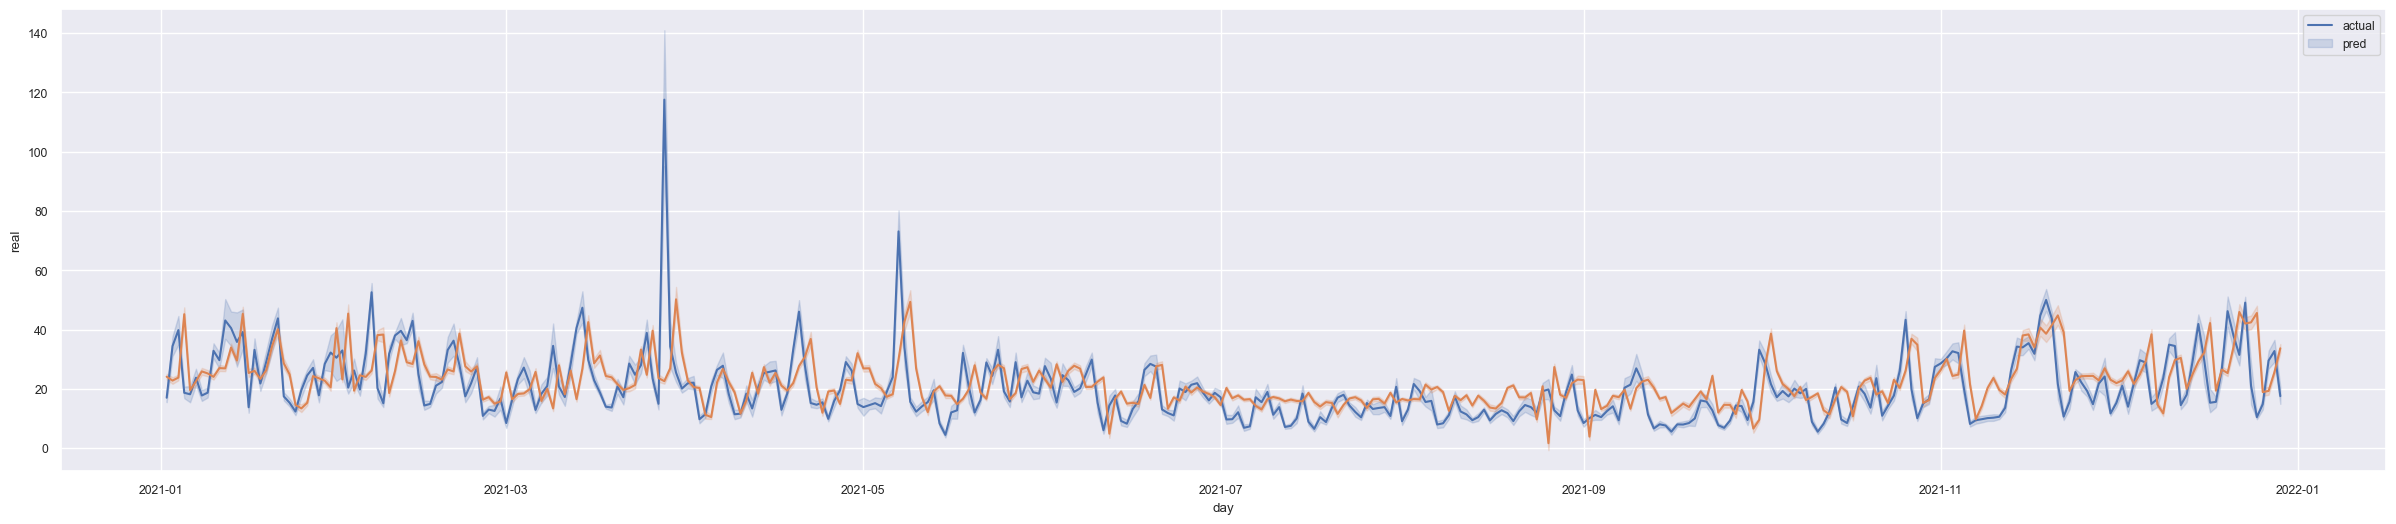

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 6))
sns.lineplot(x = 'day', y = 'real', data = rnn_air_data)
sns.lineplot(x = rnn_air_data['day'], y = rnn_air_data['pred'], data = rnn_air_data)
plt.legend(['actual','pred'])

In [ ]:
rnn_air_data['month'] = rnn_air_data['day'].astype(str).str[:-3]

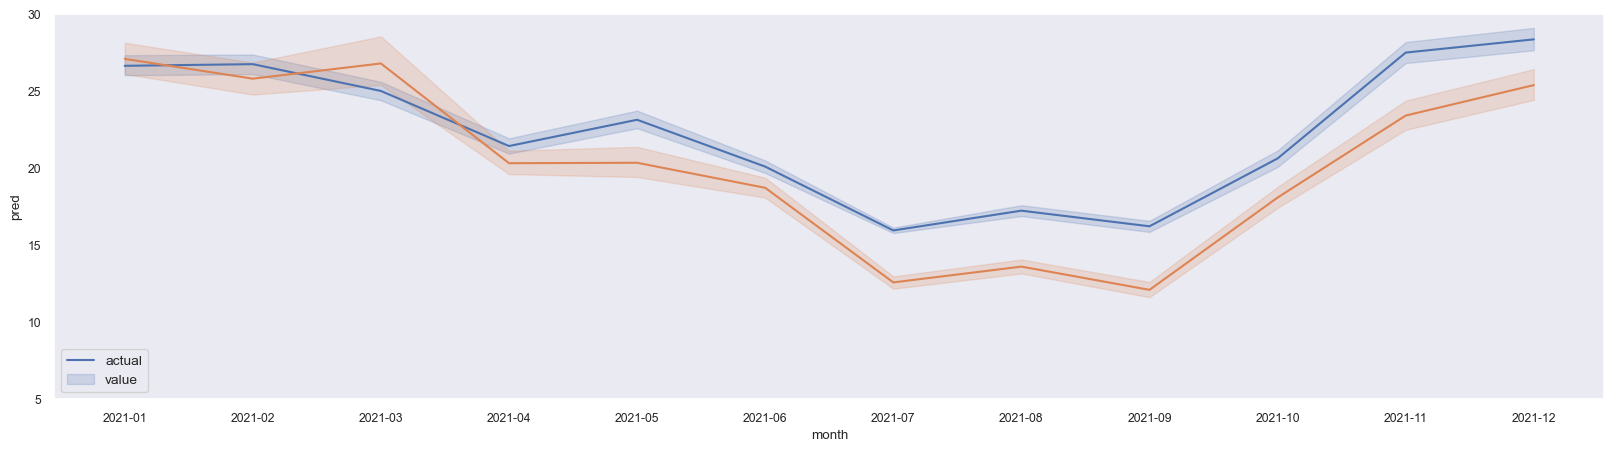

In [ ]:
# Monthly graph
plt.figure(figsize=(20, 5))
plt.ylim(5, 30)
plt.grid(False)
sns.set(font_scale = 0.9)

sns.lineplot(data = rnn_air_data, x=rnn_air_data['month'], y= rnn_air_data['pred'])
sns.lineplot(data = rnn_air_data, x=rnn_air_data['month'], y= rnn_air_data['real'])
plt.legend(['actual','value'])

In [ ]:
rnn_air_data['hour'] = rnn_air_data['date'].astype(str).str[-2:]
rnn_air_data.head()

,pred,real,day,date,month,hour
0,20.970419,23.0,2021-01-02,2021010200,2021-01,00
1,22.824078,17.0,2021-01-02,2021010201,2021-01,01
2,22.372433,13.0,2021-01-02,2021010202,2021-01,02
3,24.644419,14.0,2021-01-02,2021010203,2021-01,03
4,25.105652,15.0,2021-01-02,2021010204,2021-01,04


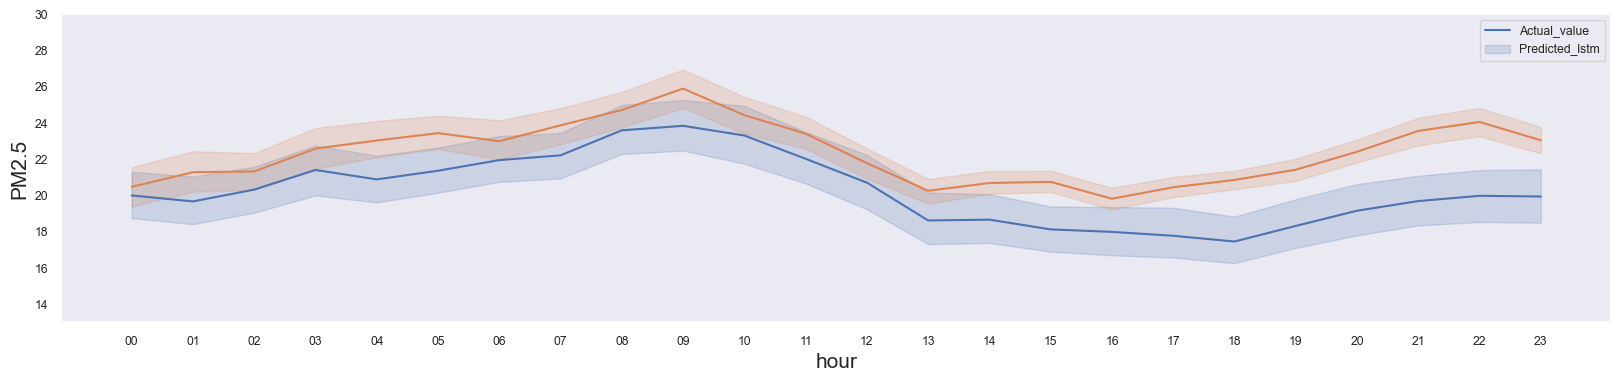

In [ ]:
#Hourly graph
plt.figure(figsize=(20, 4))
plt.ylim(13, 30)
plt.grid(False)
sns.set(font_scale = 0.8)

graph = sns.lineplot(data = rnn_air_data, x=rnn_air_data['hour'], y= rnn_air_data['real'])
graph_2 = sns.lineplot(data = rnn_air_data, x=rnn_air_data['hour'], y= rnn_air_data['pred'])
graph.set_xlabel('hour', fontsize = 15)
graph.set_ylabel('PM2.5', fontsize = 15)
plt.legend(labels = ['Actual_value', 'Predicted_lstm'])

### LSTM MODEL

In [ ]:
# LSTM
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

tf.random.set_seed(0)

model = tf.keras.models.Sequential()
model.add(LSTM(64,
               input_shape=(x_train_multi.shape[1], x_train_multi.shape[2]),
               activation='tanh',
               return_sequences=False))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(24))

model.compile(loss='mse', metrics=['mae'], optimizer=keras.optimizers.Adam(learning_rate=0.02))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm.h5', mode='min')
early_stop = EarlyStopping(monitor='val_loss',patience=300, restore_best_weights=True)

history = model.fit(x_train_multi, [y_train_multi], epochs=10000,
                    validation_data=(x_val_multi, [y_val_multi]),
                    batch_size=6,
                    callbacks=[early_stop, reduce_lr, checkpoint_cb])

total_loss, main_loss = model.evaluate(x_test_multi, [y_test_multi])

Epoch 1/10000
61/61 [==============================] - 1s 11ms/step - loss: 309.0521 - mae: 13.3296 - val_loss: 177.4401 - val_mae: 10.9074 - lr: 0.0200
Epoch 2/10000
61/61 [==============================] - 0s 7ms/step - loss: 181.5936 - mae: 9.9431 - val_loss: 114.7996 - val_mae: 7.7775 - lr: 0.0200
Epoch 3/10000
61/61 [==============================] - 0s 6ms/step - loss: 148.7097 - mae: 9.2002 - val_loss: 120.9727 - val_mae: 8.6692 - lr: 0.0200
Epoch 4/10000
61/61 [==============================] - 0s 6ms/step - loss: 153.4434 - mae: 9.1239 - val_loss: 120.8618 - val_mae: 8.5067 - lr: 0.0200
Epoch 5/10000
61/61 [==============================] - 0s 6ms/step - loss: 141.7985 - mae: 8.8020 - val_loss: 108.6536 - val_mae: 7.7826 - lr: 0.0200
Epoch 6/10000
61/61 [==============================] - 0s 6ms/step - loss: 136.4225 - mae: 8.6859 - val_loss: 108.6737 - val_mae: 7.7475 - lr: 0.0200
Epoch 7/10000
61/61 [==============================] - 0s 6ms/step - loss: 138.8312 - mae: 8.6704

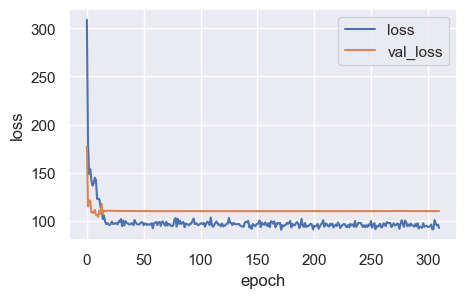

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
pred = model.predict([x_test_multi])
print('Loss', model.evaluate(x_test_multi, [y_test_multi]))

12/12 [==============================] - 0s 2ms/step - loss: 116.2949 - mae: 7.2423
Loss [116.29489135742188, 7.242330074310303]


In [ ]:
lstm_pred = pd.DataFrame((pred.reshape(pred.shape[0]*pred.shape[1])))
lstm_air_data = pd.DataFrame()
lstm_air_data['pred'] = lstm_pred[0][:-24]
lstm_air_data['real'] = real_df[0]
lstm_air_data['day'] = air_test.index[24:-48].astype(str).str[:-2]
lstm_air_data['date'] = air_test.index[24:-48]

lstm_air_data.head()

,pred,real,day,date
0,23.539787,23.0,20210102,2021010200
1,22.740400,17.0,20210102,2021010201
2,23.255850,13.0,20210102,2021010202
3,26.187502,14.0,20210102,2021010203
4,24.838104,15.0,20210102,2021010204


In [ ]:
lstm_air_data['day'] = air_test.index[24:-48].astype(str).str[:-2]
lstm_air_data['day'] = pd.to_datetime(lstm_air_data['day'])

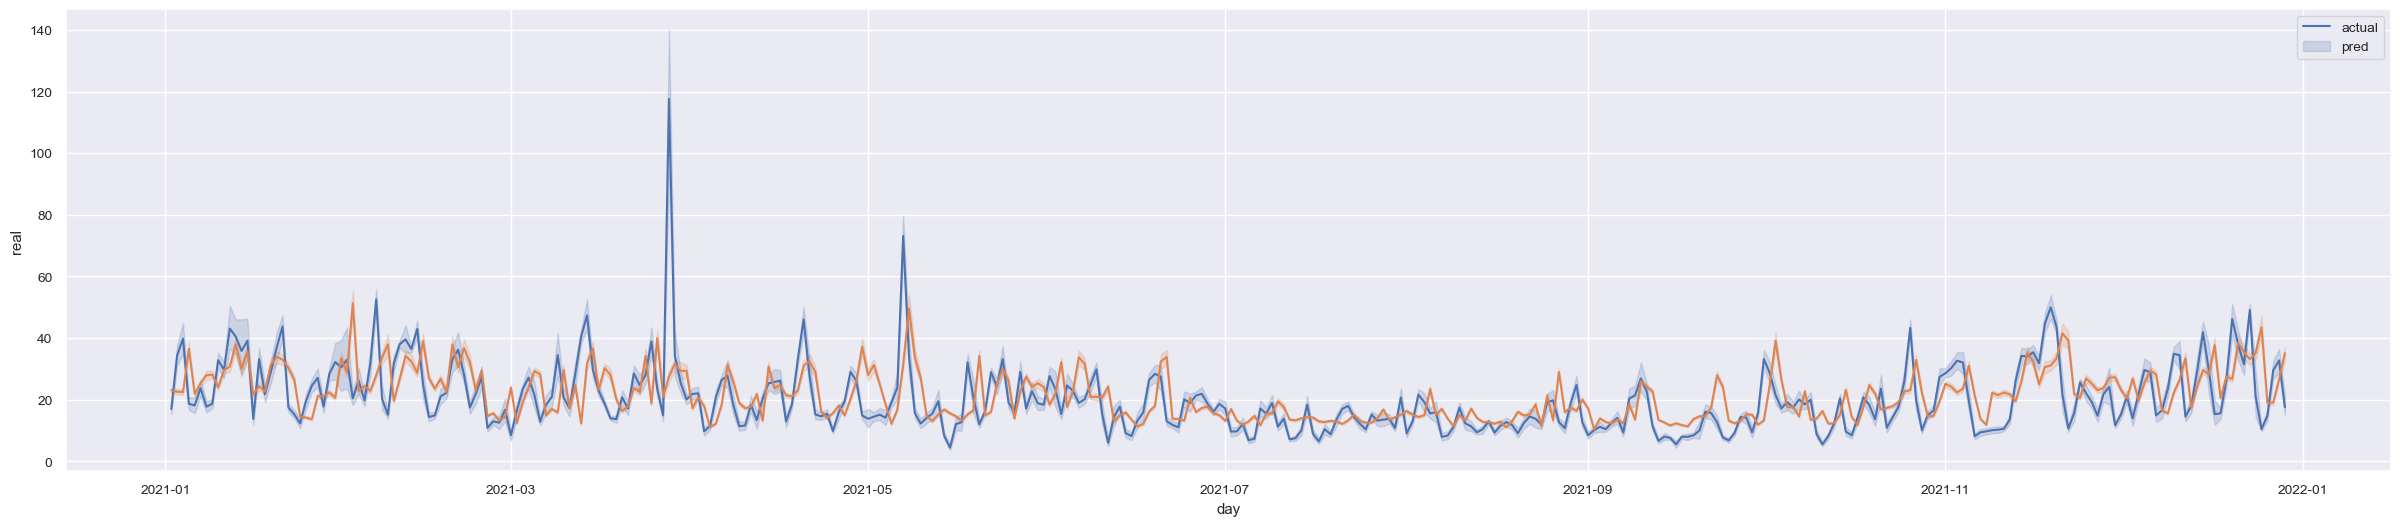

In [ ]:
plt.figure(figsize=(30, 6))
sns.lineplot(x = 'day', y = 'real', data = lstm_air_data)
sns.lineplot(x = 'day', y = 'pred', data = lstm_air_data)
plt.legend(['actual','pred'])

In [ ]:
lstm_air_data['month'] = lstm_air_data['day'].astype(str).str[:-3]
lstm_air_data['hour'] = lstm_air_data['date'].astype(str).str[-2:]
lstm_air_data.head()

,pred,real,day,date,month,hour
0,23.539787,23.0,2021-01-02,2021010200,2021-01,00
1,22.740400,17.0,2021-01-02,2021010201,2021-01,01
2,23.255850,13.0,2021-01-02,2021010202,2021-01,02
3,26.187502,14.0,2021-01-02,2021010203,2021-01,03
4,24.838104,15.0,2021-01-02,2021010204,2021-01,04


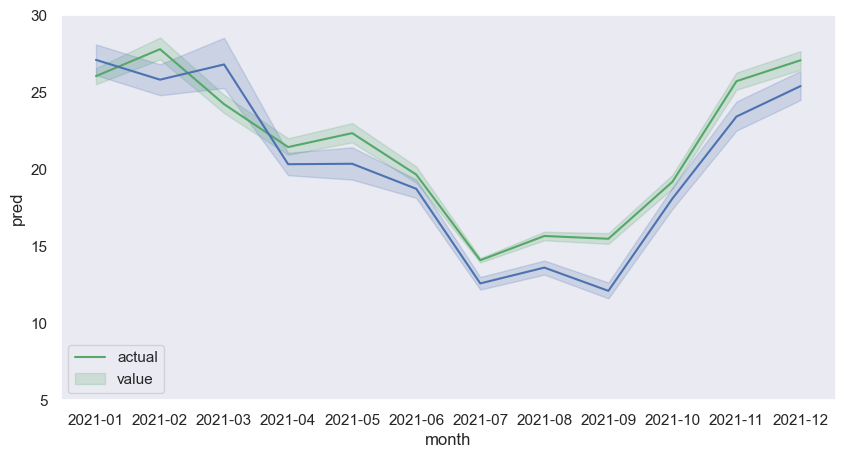

In [ ]:
# Monthly graph
plt.figure(figsize=(10, 5))
plt.ylim(5, 30)
plt.grid(False)
sns.set(font_scale = 1.0)

sns.lineplot(data = lstm_air_data, x='month', y= 'pred', color='g')
sns.lineplot(data = lstm_air_data, x='month', y= 'real', color ='b')

plt.legend(['actual','value'])

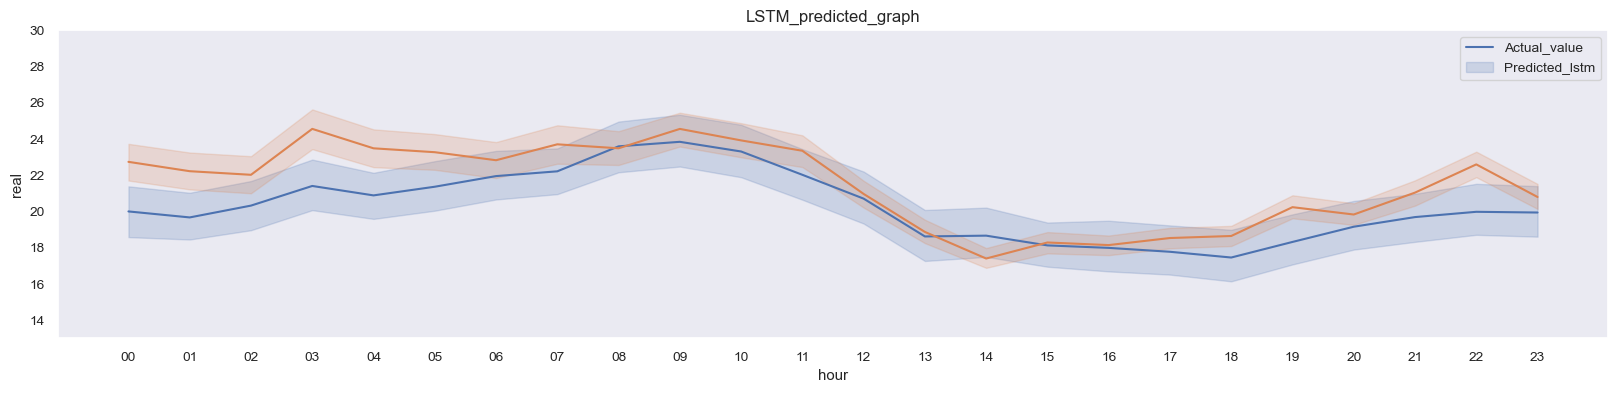

In [ ]:
#Hourly graph
plt.figure(figsize=(20, 4))
plt.ylim(13, 30)
plt.grid(False)
plt.title('LSTM_predicted_graph', fontsize = 12)
sns.set(font_scale = 0.9)

graph_2 = sns.lineplot(data = lstm_air_data, x='hour', y= 'real')
graph_2 = sns.lineplot(data = lstm_air_data, x='hour', y= 'pred')

graph.set_xlabel('hour', fontsize = 10)
graph.set_ylabel('PM2.5', fontsize = 10)
plt.legend(labels = ['Actual_value', 'Predicted_lstm'])

### CNN-LSTM

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=24, activation='relu', padding='same'), input_shape=(None, 11, 1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer= adam, loss='mse', metrics=['mae'])